In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import pickle
import xgboost

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

In [2]:
df = pd.read_csv('data/heart.csv')

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
df.shape

(303, 14)

In [4]:
df['thal'].value_counts()

2    166
3    117
1     18
0      2
Name: thal, dtype: int64

In [5]:
rowstodrop = df[df['thal']==0]
df.drop(index=[48,281],axis=0,inplace=True)

In [6]:
df['thal'].value_counts()

2    166
3    117
1     18
Name: thal, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       301 non-null    int64  
 1   sex       301 non-null    int64  
 2   cp        301 non-null    int64  
 3   trestbps  301 non-null    int64  
 4   chol      301 non-null    int64  
 5   fbs       301 non-null    int64  
 6   restecg   301 non-null    int64  
 7   thalach   301 non-null    int64  
 8   exang     301 non-null    int64  
 9   oldpeak   301 non-null    float64
 10  slope     301 non-null    int64  
 11  ca        301 non-null    int64  
 12  thal      301 non-null    int64  
 13  target    301 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 35.3 KB


In [8]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [9]:
train_df = df.iloc[:, :-1]
y = df['target'].ravel()

train_df.shape, y.shape

((301, 13), (301,))

USING CORRELATION MATRIX

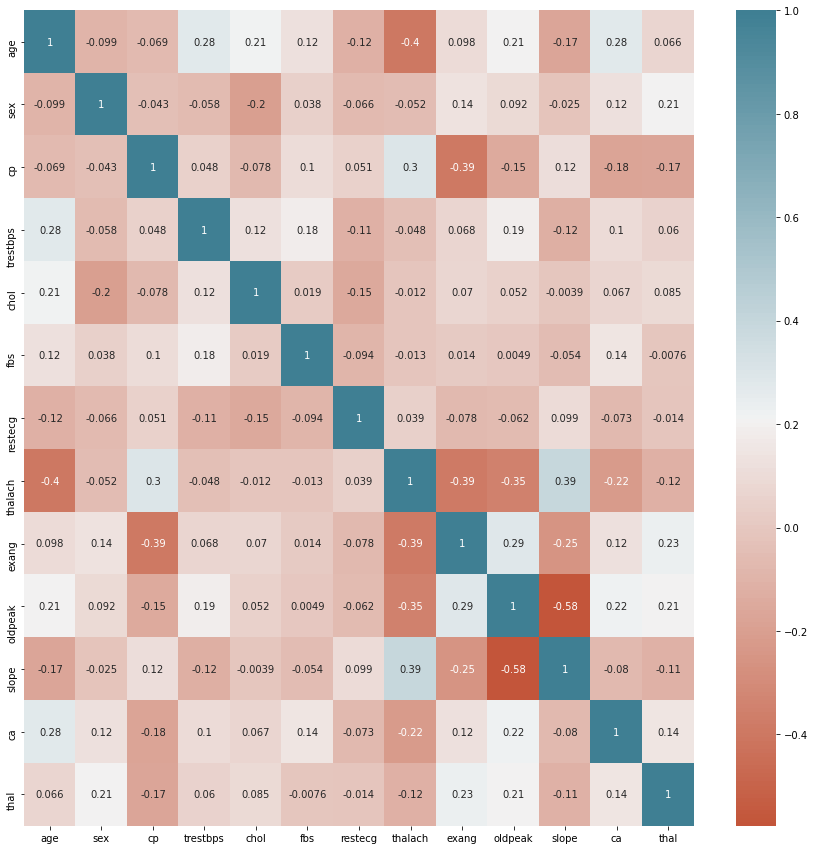

In [10]:
# correlation matrix

corr_mat = train_df.corr()
plt.figure(figsize=(15, 15))
g = sns.heatmap(corr_mat, annot=True, cmap=sns.diverging_palette(20, 220, n=200))

In [11]:
# find and remove correlated features

threshold = 0.8

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

correlation(train_df.iloc[:,:-1],threshold)

set()

In [12]:
# Select K best using Chi^2 test

ordered_rank_features = SelectKBest(score_func=chi2, k=13)
ordered_feature = ordered_rank_features.fit(train_df, y)

dfscores = pd.DataFrame(ordered_feature.scores_, columns=["Score"])
dfcolumns = pd.DataFrame(train_df.columns)

features_rank = pd.concat([dfcolumns, dfscores], axis=1)

features_rank.columns = ['Features','Score']

features_rank.nlargest(13, 'Score')

,Features,Score
7,thalach,194.513757
9,oldpeak,72.012196
11,ca,66.592015
2,cp,61.185148
8,exang,38.015155
4,chol,24.748493
0,age,23.540050
3,trestbps,14.946629
10,slope,9.575327
1,sex,7.245619


USING FEATURE IMPORTANCE - This technique gives you a score for each feature of your data,the higher the score mor relevant it is

USING INFORMATION GAIN

In [13]:
mutual_info = mutual_info_classif(train_df, y)
mutual_data = pd.Series(mutual_info, index=train_df.columns)
mutual_data.sort_values(ascending=False)

thal        0.171205
cp          0.129374
ca          0.120476
exang       0.106301
oldpeak     0.104957
chol        0.083488
thalach     0.072448
slope       0.039101
sex         0.020903
restecg     0.017341
trestbps    0.010618
fbs         0.004145
age         0.000000
dtype: float64

**FINAL SELECTION**

In [14]:
final_selected_features = ['ca', 'cp', 'exang', 'thal', 'oldpeak', 'thalach','age']

In [15]:
X = train_df[final_selected_features]

In [16]:
X.shape

(301, 7)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.15, random_state=42)

RANDOMFOREST

In [18]:
# using random forest classifier

rfc = RandomForestClassifier() # ravel : from (n,m) => (n,)
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [19]:
# random forest classifier accuracy:
y_preds = rfc.predict(X_test)
print("Accuracy : {:.2f}%".format(accuracy_score(y_test, y_preds)*100))

Accuracy : 84.78%


XGBOOST

In [20]:
# using xgboost

# hyperparameter optimization

params = {
    "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "max_depth"        : [3, 4, 5, 6, 8, 10, 12, 15],
    "min_child_weight" : [1, 3, 5, 7],
    "gamma"            : [0.0, 0.1, 0.2 , 0.3, 0.4],
    "colsample_bytree" : [0.3, 0.4, 0.5, 0.7]
}

clf = xgboost.XGBClassifier()

random_search = RandomizedSearchCV(
    clf, 
    param_distributions=params, 
    n_iter=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=5, 
    verbose=0
)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=Non

In [21]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [22]:
classifier = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=7, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

classifier.fit(X_train, y_train)

ValueError: Label encoder was removed in 1.6.

In [ ]:
# xgboost classifier accuracy:
y_preds = classifier.predict(X_test)
print("Accuracy : {:.2f}%".format(accuracy_score(y_test, y_preds)*100))

Accuracy : 89.13%


In [ ]:
score = cross_val_score(classifier, X_train, y_train, cv=10)
print(score.mean())

[14:40:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/lumiq/anaconda3/envs/health/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/lumiq/anaconda3/envs/health/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:40:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/lumiq/anaconda3/envs/health/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:40:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/lumiq/anaconda3/envs/health/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:40:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/lumiq/anaconda3/envs/health/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:40:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/lumiq/anaconda3/envs/health/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:40:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/lumiq/anaconda3/envs/health/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/lumiq/anaconda3/envs/health/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:40:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:40:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/lumiq/anaconda3/envs/health/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:40:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/lumiq/anaconda3/envs/health/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:40:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.826923076923077


In [ ]:
# saving trained model
filename = 'heart_disease.pickle.dat'
pickle.dump(classifier, open(filename, 'wb'))

In [ ]:
df.iloc[0][final_selected_features]

ca           0.0
cp           3.0
exang        0.0
thal         1.0
oldpeak      2.3
thalach    150.0
age         63.0
Name: 0, dtype: float64

In [ ]:
classifier.predict(np.array(X_test[0]).reshape(1,-1))

array([0])